In [ ]:
##### Fig. 6 - Task modulation effect on phonemic representations in the left pSTS
#
# written by S-C. Baek
# updated date: 16.12.2024
#

In [1]:
# import packages
import os
import sys
import pickle

import numpy as np

from scipy import stats as stats

import mne
from mne.stats.multi_comp import fdr_correction

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# path settings
FIGDIR  = os.getcwd()
MAINDIR = os.path.abspath('..')
DATADIR = MAINDIR + os.sep + 'data/'
PYDIR   = MAINDIR + os.sep + 'code' + os.sep + 'python/'

In [3]:
# add path to PYDIR to import functions
if PYDIR not in sys.path:
    sys.path.insert(1, PYDIR)
from utils import fisher_z_transform, sort_rois_subset

In [4]:
# subjects
s = os.listdir(DATADIR)
subjects = [i for i in s if 'sub-' in i]
subjects.sort()
n_subjects = len(subjects)

In [5]:
 # colors
cmap = matplotlib.colormaps['tab10']
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_indices = np.array([9, 6, 2, 1, 4])
colors = np.array(colors)[color_indices]

In [ ]:
# Fig. 6a - general representations of phonemes enhanced by the phoneme task in the left pSTS

In [6]:
# linguistic element to plot
elements = ['phoneme', 'prosody']
ei = 0
element = elements[ei]

# onset of relevant acoustic landmarks
if element == 'phoneme':
    tonoff = np.array([0.026, 0.062]) # voicing, in s
else:
    tonoff = np.array([0.184, 0.250]) # pitch divergence, in s

In [7]:
# get data configuration
fname = DATADIR + subjects[0] + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni.pickle'
with open(fname, 'rb') as f:
    tmp = pickle.load(f)
n_rois, n_times, n_models = tmp['rsa_vals'].shape
    
# reconstrunct time info.
tmin  = tmp['tmin']
tstep = tmp['tstep']
tmax  = tmin + tstep*(n_times-1)
times = np.linspace(tmin, tmax, n_times)

# ROI labels for plotting
rois = np.array(tmp['labels'])
del fname, tmp

In [8]:
# import data
X = np.zeros( (n_rois, n_times, n_subjects) ) # ROI-RSA during the relevant task
Y = np.zeros( (n_rois, n_times, n_subjects) ) # ROI-RSA during the irrelevant task

# loop over participants
for subi, subject in enumerate(subjects):   
    
    # prefix to fname
    prefix = DATADIR + subject + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_gen'
    
    # data during the relevant task
    fname = prefix + '_att.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    X[:,:,subi] = rsa_rois['rsa_vals']
    del fname, rsa_rois
    
    # data during the irrelevant task
    fname = prefix + '_ign.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    Y[:,:,subi] = rsa_rois['rsa_vals']
    del fname, rsa_rois
    
# Fisher Z transform
X = fisher_z_transform(X, sqrt=True)
Y = fisher_z_transform(Y, sqrt=True)

# difference between the tasks
t0Idx = np.argmin(np.abs(times)) # onset index
X = X - np.mean(X[:, :t0Idx, :], axis=1)[:, np.newaxis, :] # baseline correction
Y = Y - np.mean(Y[:, :t0Idx, :], axis=1)[:, np.newaxis, :] # baseline correction
Z = X - Y

In [9]:
# only consider the ROIs that showed significant relevant general representations
roi_subset_indices = sort_rois_subset(element)
rois_subset = rois[roi_subset_indices]
n_rois_subset = len(rois_subset)
print(rois_subset)

['L-PAC' 'L-aSTS' 'L-pSTS' 'R-PAC' 'R-aSTS' 'R-pSTS']


In [10]:
 # import ROI-wise cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_gen_att_vs_ign_p05.pickle'
with open(fname, 'rb') as f:
    cluster_stats_rois = pickle.load(f)

In [11]:
# FDR correction based on the minimum p-value of each ROI
pvals = list()
for stat in cluster_stats_rois:
    if len(stat[1]) > 0:
        pvals.append(np.min(stat[1]))
    else:
        pvals.append(0.99)
reject, pvals_correct = fdr_correction(pvals) # apply FDR correction
factor = pvals_correct / pvals

sig_clusters = list()
sig_clusters_pval = list()
for i, stat in enumerate(cluster_stats_rois):
    if reject[i]:
        # points consisting of a cluster
        sig_ids = np.where(stat[1] * factor[i] < 0.05)[0] # identifying the indices of significant clusters
        sig_pnts = [stat[0][idx] for idx in sig_ids] 
        sig_clusters.append(sig_pnts)
        
        # cluster-wise p-valse 
        sig_pvals = [stat[1][idx] for idx in sig_ids]
        sig_clusters_pval.append(sig_pvals)
    else:
        # points consisting of a cluster
        sig_pnts = [] 
        sig_clusters.append(sig_pnts)
        
        # cluster-wise p-valse 
        sig_pvals = []
        sig_clusters_pval.append(sig_pvals)

# group cluster extents and p-values
sig_clusters_rois = (sig_clusters, sig_clusters_pval)

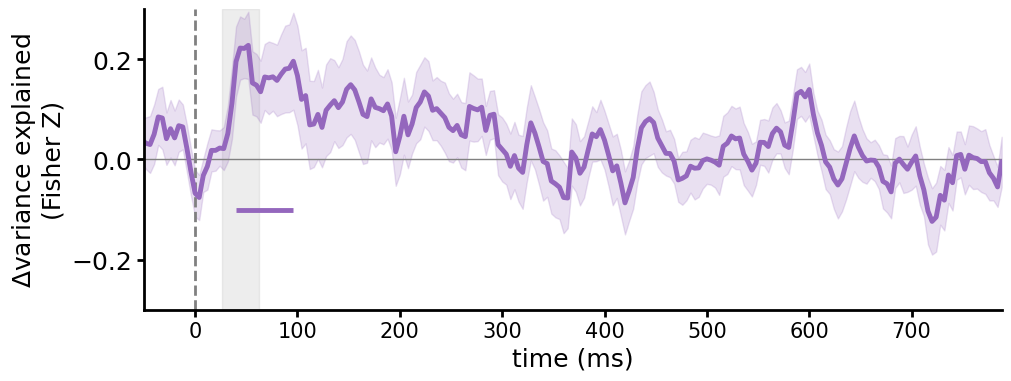

In [12]:
# group-level data for plotting
m     = np.mean(Z, axis=-1) # mean
sem   = np.std(Z, axis=-1) / np.sqrt(n_subjects) # sem
upper = m + sem
lower = m - sem

# range of x- & y-axis
xlim  = (-50, times[-1]*1e3)
x0Idx = np.argmin(np.abs(times - xlim[0]*1e-3))
ylim  = (-0.3, 0.3)

# figure
fig, ax = plt.subplots(figsize=(10,3.7), constrained_layout=True)

# accessories first
ax.vlines(0, ylim[0], ylim[1], linewidth=2.0, linestyle='--', color=np.ones(3)*0.5) # stimulus onset
ax.hlines(0, xlim[0], xlim[1], linewidth=1.0, color=np.ones(3)*0.5)
ax.fill_between(tonoff[:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                color='#A9A9A9', alpha=0.2) # acoustic landmark

# plot task-modulation effect
for roii in range(n_rois_subset):
    if sig_clusters_rois[0][roii]: # plotting only significant ROIs for legend
        ax.plot(1e3*times[x0Idx:], m[roi_subset_indices[roii],x0Idx:], 
                color=colors[roi_subset_indices[roii]%5], linewidth=3.5, 
                label=rois[roi_subset_indices[roii]]) # mean
        ax.fill_between(1e3*times[x0Idx:], # sem
                        upper[roi_subset_indices[roii],x0Idx:], 
                        lower[roi_subset_indices[roii],x0Idx:], 
                        color=colors[roi_subset_indices[roii]%5], alpha=0.2)

# mark a significant interval 
for roii in range(n_rois_subset):
    sig_points = sig_clusters_rois[0][roii] # cluster extents in samples
    for pnt in sig_points:
        ax.hlines(-0.1, times[t0Idx+pnt[0][0]]*1e3, times[t0Idx+pnt[0][-1]]*1e3,
                  color=colors[roi_subset_indices[roii] % 5], linewidth=3.5)
        
# accessories
ax.set_xlim(xlim[0], xlim[-1])
ax.tick_params(axis='x', labelsize=15)
ax.set_xlabel('time (ms)', fontsize=18)
ax.set_ylim(ylim[0], ylim[-1])
ax.set_yticks([-0.2, 0, 0.2])
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel(r'$\Delta$variance explained' + '\n(Fisher Z)', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(length=5, width=2)
ax.yaxis.set_tick_params(length=5, width=2)

In [ ]:
# Fig. 6b,c - task-modulation effect on acoustic and categorical representations of phonemes in the left pSTS

In [13]:
# specification
element = 'phoneme'

# model types
models = ['acoust', 'cat']
n_models = len(models)

# L-pSTS
roi  = 'L-pSTS'
roii = [ri for ri, r in enumerate(rois) if r == roi][0]

# reset colormap
cmap = matplotlib.colormaps['tab20']
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_indices = roii*2
colors = np.array(colors)[np.array([color_indices, color_indices+1])]

# onset of relevant acoustic landmarks
tonoff = np.array([0.026, 0.062])

In [14]:
# import data
X = np.zeros( (n_times, n_models, n_subjects) ) # ROI-RSA during the relevant task
Y = np.zeros( (n_times, n_models, n_subjects) ) # ROI-RSA during the irrelevant task

# loop over participants
for subi, subject in enumerate(subjects):   
    
    # prefix to fname
    prefix = DATADIR + subject + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni'
    
    # data during the relevant task
    fname = prefix + '_att.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    X[:,:,subi] = rsa_rois['rsa_vals'][roii,:,:]
    del fname, rsa_rois
    
    # data during the irrelevant task
    fname = prefix + '_ign.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    Y[:,:,subi] = rsa_rois['rsa_vals'][roii,:,:]
    del fname, rsa_rois
    
# Fisher Z transform
X = fisher_z_transform(X, sqrt=True)
Y = fisher_z_transform(Y, sqrt=True)

# difference between the tasks
t0Idx = np.argmin(np.abs(times)) # onset index
X = X - np.mean(X[:t0Idx, :, :], axis=0)[np.newaxis, :, :] # baseline correction
Y = Y - np.mean(Y[:t0Idx, :, :], axis=0)[np.newaxis, :, :] # baseline correction
Z = X - Y

In [15]:
# import ROI-wise cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni_att_vs_ign_p05.pickle'
with open(fname, 'rb') as f:
    cluster_stats_models = pickle.load(f)

In [16]:
# sort out significant clusters for each model
sig_clusters_models = list()

# loop over models
for cluster_stats_roi in cluster_stats_models:

    # find significant clusters
    
    if len(cluster_stats_roi[0]) > 0:
        sig_ids = np.where(cluster_stats_roi[1] < 0.05)[0]
        sig_clusters = [cluster_stats_roi[0][idx] for idx in sig_ids]
        sig_clusters_pval = [cluster_stats_roi[1][idx] for idx in sig_ids]
    else:
        sig_clusters = []
        sig_clusters_pval = []
    
    # put model-wise results into a bigger list
    sig_clusters_roi = (sig_clusters, sig_clusters_pval)
    sig_clusters_models.append(sig_clusters_roi)

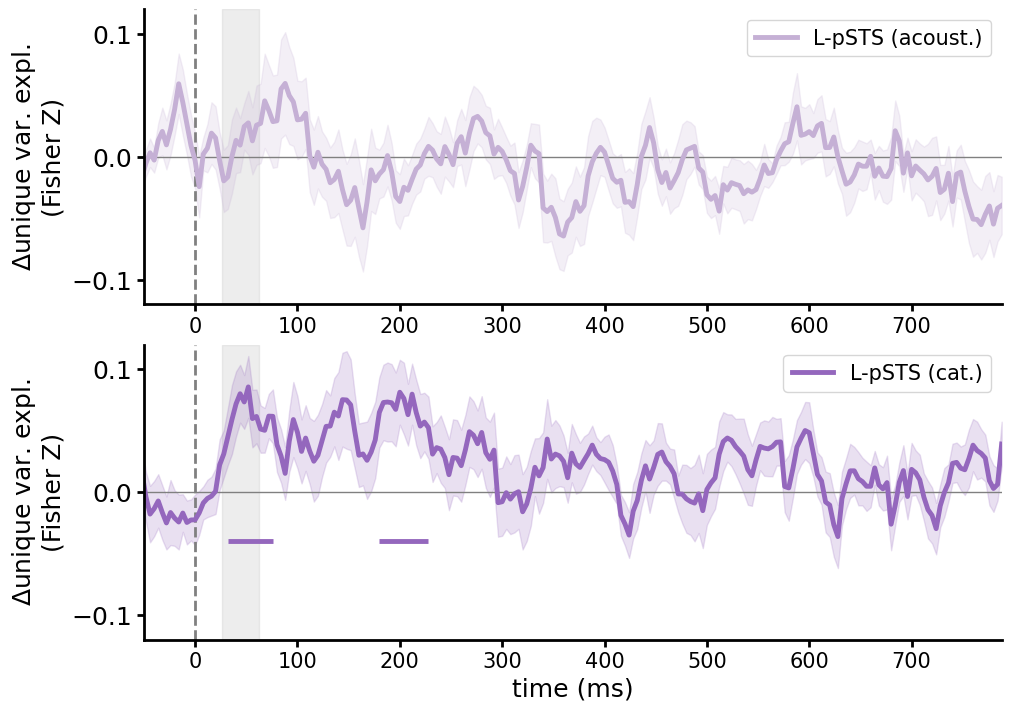

In [17]:
# group-level data for plotting
m     = np.mean(Z, axis=-1) # mean
sem   = np.std(Z, axis=-1) / np.sqrt(n_subjects) # sem
upper = m + sem
lower = m - sem

# range of x- & y-axis
xlim  = (-50, times[-1]*1e3)
x0Idx = np.argmin(np.abs(times - xlim[0]*1e-3))
ylim  = (-0.12, 0.12)

# figure
fig, ax = plt.subplots(2,1, figsize=(10,7), constrained_layout=True)

# loop over n_models
for i in range(n_models):

    # accessories first
    ax[i].vlines(0, ylim[0], ylim[1], linewidth=2.0, linestyle='--', color=np.ones(3)*0.5) # stimulus onset
    ax[i].hlines(0, xlim[0], xlim[1], linewidth=1.0, color=np.ones(3)*0.5)
    ax[i].fill_between(tonoff[:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                       color='#A9A9A9', alpha=0.2) # acoustic landmark

    # plot task-modulation effect
    is_sig = len(sig_clusters_models[i][0]) > 0
    ax[i].plot(1e3*times[x0Idx:], m[x0Idx:,i], color=colors[0] if is_sig else colors[1], 
               linewidth=3.5, label=roi + (' (%s.)') % models[i]) # mean
    ax[i].fill_between(1e3*times[x0Idx:], upper[x0Idx:,i], lower[x0Idx:,i], 
                       color=colors[0] if is_sig else colors[1], alpha=0.2) # sem

    # mark a significant interval
    if is_sig:
        sig_points = sig_clusters_models[i][0] # cluster extents in samples
        for pnt in sig_points:
            ax[i].hlines(-0.1*2/5, times[t0Idx+pnt[0][0]]*1e3, times[t0Idx+pnt[0][-1]]*1e3,
                         colors=colors[0] if is_sig else colors[1], linewidth=3.5)

    # accessories
    ax[i].legend(loc='upper right', fontsize=15)
    ax[i].set_xlim(xlim[0], xlim[-1])
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].set_xlabel('time (ms)', fontsize=18) if i == 1 else ax[i].set_xlabel('')
    ax[i].set_ylim(ylim[0], ylim[-1])
    ax[i].set_yticks([-0.1, 0, 0.1])
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].set_ylabel(r'$\Delta$unique var. expl.' + '\n(Fisher Z)', fontsize=18)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
    ax[i].xaxis.set_tick_params(length=5, width=2)
    ax[i].yaxis.set_tick_params(length=5, width=2)

In [ ]:
# Fig. 6d- lateralization of task-modulation effect on categorical representations of phonemes in the left pSTS

In [18]:
# specification
element = 'phoneme'
model = 'cat'

# roi to plot
roi  = 'L-pSTS'
roii = [ri for ri, r in enumerate(rois) if r == roi][0]
roi  = roi[2:] # crop the hemisphere

# reset colormap
cmap = matplotlib.colormaps['tab10']
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color = np.array(colors)[roii]

In [19]:
# import data
X = np.zeros( (n_rois, n_times, n_subjects) ) # ROI-RSA during the relevant task
Y = np.zeros( (n_rois, n_times, n_subjects) ) # ROI-RSA during the irrelevant task

# loop over participants
for subi, subject in enumerate(subjects):   
    
    # prefix to fname
    prefix = DATADIR + subject + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni'
    
    # data during the relevant task
    fname = prefix + '_att.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    X[:,:,subi] = rsa_rois['rsa_vals'][:,:,1]
    del fname, rsa_rois
    
    # data during the irrelevant task
    fname = prefix + '_ign.pickle'
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    Y[:,:,subi] = rsa_rois['rsa_vals'][:,:,1]
    del fname, rsa_rois
    
# Fisher Z transform
X = fisher_z_transform(X, sqrt=True)
Y = fisher_z_transform(Y, sqrt=True)

# difference between the tasks
t0Idx = np.argmin(np.abs(times)) # onset index
X = X - np.mean(X[:,:t0Idx, :], axis=1)[:,np.newaxis, :] # baseline correction
Y = Y - np.mean(Y[:,:t0Idx, :], axis=1)[:,np.newaxis, :] # baseline correction
Z = X - Y

# # difference between the hemispheres
n_rois_hemi = int(n_rois/2)
LR = Z[0:n_rois_hemi] - Z[n_rois_hemi:]
LR = LR[roii]

In [20]:
# parameters for cluster statistics
p_threshold = 0.05
tail = 0 # left vs. right
n_permutations = 100000
n_jobs = 12

# run cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep +\
        'rsa_rois_' + element + '_' + model + '_left_vs_right_p05.pickle'
if os.path.exists(fname):
    print('Existing results of Task-modul X Hemi. for %s (%s) in %s ...' % (element, model, roi))
else:
    print('Run statistical inference of Task-modul X Hemi. for %s (%s) in %s ...' % (element, model, roi))
    t_threshold = stats.distributions.t.ppf(1 - (p_threshold/2), df=n_subjects-1)
    print('two-tailed t-test with t-threshold of %.3f (p=%.3f)' % (t_threshold, p_threshold))
    
    # cluster statistics
    data = LR[t0Idx:,:].T # now, to n_subjects X n_times
    _, clusters, cluster_p_values, _ = mne.stats.spatio_temporal_cluster_1samp_test(
        data, 
        adjacency=None, # make the ROIs independent
        max_step=1,
        tail=tail, # two-tail
        threshold=t_threshold,
        n_permutations=n_permutations,
        n_jobs=n_jobs, 
        buffer_size=None, 
        verbose=True)
    
    # clustering result as tuple
    cluster_stats_roi = (clusters, cluster_p_values)
    
    # save the result
    with open(fname, 'wb') as f:
        pickle.dump(cluster_stats_roi, f)
    f.close()

Existing results of Task-modul X Hemi. for phoneme (cat) in pSTS ...


In [21]:
# import ROI-wise cluster statistics
with open(fname, 'rb') as f:
    cluster_stats_roi = pickle.load(f)

In [22]:
# sort out significant clusters for each model
sig_ids = np.where(cluster_stats_roi[1] < 0.05)[0]
sig_clusters = [cluster_stats_roi[0][idx] for idx in sig_ids]
sig_clusters_pval = [cluster_stats_roi[1][idx] for idx in sig_ids]

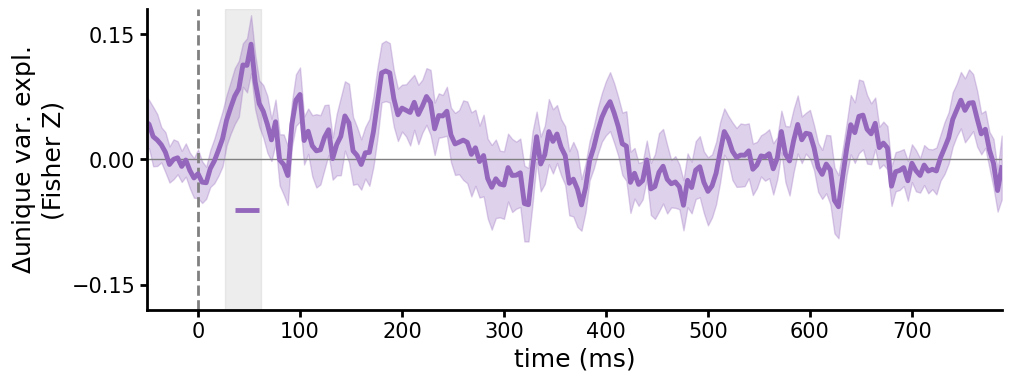

In [23]:
# group-level data for plotting
m     = np.mean(LR, axis=-1) # mean
sem   = np.std(LR, axis=-1) / np.sqrt(n_subjects) # sem
upper = m + sem
lower = m - sem

# range of x- & y-axis
xlim  = (-50, times[-1]*1e3)
x0Idx = np.argmin(np.abs(times - xlim[0]*1e-3))
ylim  = (-0.18, 0.18)

# figure
fig, ax = plt.subplots(figsize=(10,3.7), constrained_layout=True)

# accessories first
ax.vlines(0, ylim[0], ylim[1], linewidth=2.0, linestyle='--', color=np.ones(3)*0.5) #'#A9A9A9'
ax.hlines(0, xlim[0], xlim[1], linewidth=1.0, color=np.ones(3)*0.5)
ax.fill_between(tonoff[:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], color='#A9A9A9', alpha=0.2)
    
# plot mean & s.e.m
ax.plot(1e3*times[x0Idx:], m[x0Idx:], color=color, linewidth=3.5) # mean
ax.fill_between(1e3*times[x0Idx:], upper[x0Idx:], lower[x0Idx:], color=color, alpha=0.3)
    
# mark a significant interval
sig_points = sig_clusters[0]
for pnt in sig_points:
    ax.hlines(-0.1*3/5, times[pnt[0]+t0Idx]*1e3, times[pnt[-1]+t0Idx]*1e3, color=color, linewidth=3.5)

# accessories
ax.set_xlim(xlim[0], xlim[-1])
ax.tick_params(axis='x', labelsize=15)
ax.set_xlabel('time (ms)', fontsize=18)
ax.set_ylim(ylim[0], ylim[-1])
ax.set_yticks([-0.15, 0, 0.15])
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel(r'$\Delta$unique var. expl.' + '\n(Fisher Z)', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(length=5, width=2)
ax.yaxis.set_tick_params(length=5, width=2)